### Applications of Rough Paths: Computational Signatures and Data Science (Jul 6 - 9, 2021)

This tutorial will introduce two important transforms for signatures. The first one helps in the presence of missing data, and the second one called *visibility transformation* helps in incorporating initial (static) conditions to signature.

### 1. handling missing data

** 1) Missing data type**: missing at random, missing not at random.

** 2) Three ways**: imputation; omission; analysis

**3) Signature plays a role ** (you may refer to this to-be-updated preprint https://arxiv.org/abs/2006.15030)

*One example*: 

assume we are collecting participants' weekly ASRM score. Here is the ASRM scores we collected from participant A

Week 1. ASRM score $n_1$

Week 2. 1 missing report

Week 3. 1 missing report

Week 4. ASRM score $n_2$

Week 5. ASRM score $n_3$

*Step 1.* We may represent it as time-augmented cumulative data:
\begin{equation*}
\begin{bmatrix}
 n_1&0 &1\\
n_1 &1 &2\\
n_1 & 2 &3\\
n_1+n_2 &2 &4\\
 n_1+n_2+n_3 &2 &5
\end{bmatrix}\\
\\
\text{cASRM, cCount,Time}
\end{equation*}

*Step 2.* Other transforms;

*Step 3.* Chose your (log)-signature transform with some order.

In [1]:
import numpy as np
import iisignature



def missing_transform(data,time=True,missing_value=-1.0,initial_replace=0):
    """
    input:
    d*m data
    
    output:
    (d+1)*m-dimensional or (d+2)*m-dimensional
    """

    ## creat a new 'output_data' object such that 
    ## 1. output_data contains original data and 
    ## 2. the number of rows for output_data == the number of rows for original data
    ## 3. the number of columns for output_data will be larger than the number of columns for the original data
    output_data=np.zeros((data.shape[0],data.shape[1]+1+int(time)))
    output_data[:,:data.shape[1]]=data
    
    for j in range(data.shape[1]):
        #### we check each row of the original data
        
        missing_ids=np.where(data[:,j]==missing_value)[0]
        missing_num=len(np.where(data[:,j]==missing_value)[0])
        
        ### if missing happened in one week, then we add one for the missing count cell 
        ### (note here we do not have accumulative values)
        output_data[missing_ids,data.shape[1]]+=1
        
        if missing_num>0:
            
            ### If missing number < week num and the first week is missing, we can compute the mean of rest 
            ### to replace, otherwise, we indicate the number as initial_replace
#             if missing_num<data.shape[0]:
#                 initial_replace=(np.sum(data)+missing_num)/(data.shape[0]-missing_num)

                
            if data[0,j]==missing_value:
                    output_data[0,j]=initial_replace
            
            ### fill-forward
            for idx in range(data.shape[0]):
                
                if idx!=0:
                    if idx in missing_ids:
                        output_data[idx,j]=output_data[idx-1,j]
                    else:                   
                        output_data[idx,j]+=output_data[idx-1,j]
    
    ## cumulative missing counts
    output_data[:,data.shape[1]]=np.cumsum(output_data[:,data.shape[1]])
    
    if time:   
        output_data[:,-1]=np.arange(data.shape[0])+1
    
    return output_data
    

      

In [2]:
asrm_A=np.array([11,2,3,-1,-1])  

processed_data_A=missing_transform(asrm_A.reshape(-1,1),time=True,missing_value=-1.0,initial_replace=0)
print(processed_data_A)
iisignature.sig(processed_data_A, 3)

[[11.  0.  1.]
 [13.  0.  2.]
 [16.  0.  3.]
 [16.  1.  4.]
 [16.  2.  5.]]


array([ 5.        ,  2.        ,  4.        , 12.5       , 10.        ,
       14.5       ,  0.        ,  2.        ,  2.        ,  5.5       ,
        6.        ,  8.        , 20.83333333, 25.        , 32.16666667,
        0.        , 10.        , 10.        ,  8.16666667, 19.        ,
       21.83333333,  0.        ,  0.        ,  0.        ,  0.        ,
        1.33333333,  1.33333333,  0.        ,  1.33333333,  1.33333333,
        9.66666667, 11.        , 14.33333333,  0.        ,  5.33333333,
        5.33333333,  3.83333333,  9.33333333, 10.66666667])

In [4]:
asrm_qids_B=np.array([[11,2,3,-1,-1],[-1,3,5,-1,7]])  
processed_data_B=missing_transform(asrm_qids_B.T,time=True,missing_value=-1.0,initial_replace=0)
print(processed_data_B)

from sklearn import preprocessing
iisignature.sig(preprocessing.normalize(processed_data_B), 2)

[[11.  0.  1.  1.]
 [13.  3.  1.  2.]
 [16.  8.  1.  3.]
 [16.  8.  3.  4.]
 [16. 15.  4.  5.]]


array([-2.91535623e-01,  6.56532164e-01,  8.49082803e-02,  1.28677091e-01,
        4.24965097e-02, -6.54094677e-02, -1.41265717e-02, -8.91623707e-03,
       -1.25993046e-01,  2.15517241e-01,  4.56928063e-02,  3.58890464e-02,
       -1.06272166e-02,  1.00522108e-02,  3.60470804e-03,  2.69477474e-04,
       -2.85977189e-02,  4.85916028e-02,  1.06562731e-02,  8.27889691e-03])

### 2. visibility transformation

**1) for continuous path**

\begin{align*}
&\mbox{Path X}\stackrel{Signature}{\Longrightarrow} \mbox{Incremental effects of X}
\end{align*}

In [61]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

Suppose we have a 2-dim path:

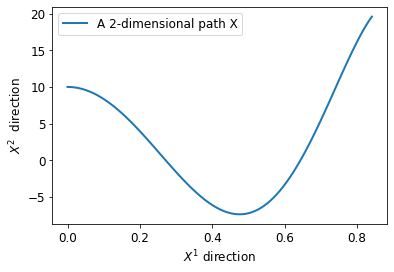

In [71]:
time_range=np.linspace(0,1,100)
x_path=np.sin(time_range)
y_path=10*(np.square(time_range)+np.cos(time_range*6))
z_path=np.zeros(len(time_range))+1

fontsize=12
linewidth=2
plt.figure(figsize=(6,4))
plt.plot(x_path,y_path,linewidth=linewidth, label="A 2-dimensional path X")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('$X^1$ direction',fontsize=fontsize)

plt.ylabel('$X^2$  direction',fontsize=fontsize)
plt.show()

In [76]:
def visibility_visualization1(x_path,y_path):
    z_path=np.zeros(len(time_range)+2,dtype=int)
    
    for i in range(len(z_path))[2:]:
        z_path[i]=1
        
    x_path_m1=x_path[0]
    y_path_m1=y_path[0]
    x_path_m2=0
    y_path_m2=0

    x_new_path=np.insert(x_path, [0,1],[x_path_m2,x_path_m1])
    y_new_path=np.insert(y_path, [0,1],[y_path_m2,y_path_m1])
    
    
    return x_new_path, y_new_path, z_path

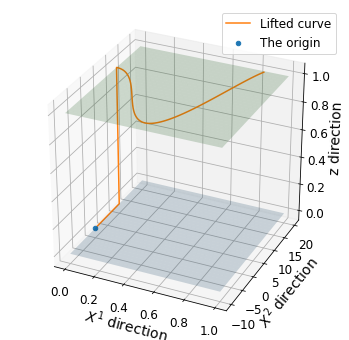

In [78]:
x,y,z=visibility_visualization1(x_path,y_path)
yy, xx = np.meshgrid(np.arange(31)-10,range(2))
zz = yy*0

yy1, xx1 = np.meshgrid(np.arange(31)-10,range(2))
zz1 = yy1*0+1

mpl.rcParams['legend.fontsize'] = 12

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, zz,alpha=0.2)
ax.plot(x, y, z, label='Lifted curve')
ax.scatter(0,0,0,label="The origin")
ax.plot_surface(xx1, yy1, zz1,alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()
ax.view_init(30, 360-65)

ax.set_xlabel('$X^1$ direction',fontsize=14)

ax.set_ylabel('$X^2$ direction',fontsize=14)
ax.set_zlabel('z direction',fontsize=14)
#ax.view_init(30, 360-45)
#ax.xticks(fontsize=12)
#ax.yticks(fontsize=12)
plt.show()

 #### This is called *I-Visibility transformation*
 
 \begin{align*}
& \mbox{Path X}\stackrel{\mbox{VT}}{\Longrightarrow}\mbox{Path } \bar{\mbox{X}}\stackrel{\mbox{Signature}}{\Longrightarrow}\mbox{Positional and incremental effects of path X}
\end{align*}

This has been shown in https://arxiv.org/pdf/2004.04006.pdf

#### 2) for discrete data

Given streamed data $\mathbf{X}=\big(\mathbf{x}_1,\ldots,\mathbf{x}_n\big)$, $\mathbf{x}_i\in \mathbb{R}^d$. The standard way to use signature is:

\begin{align*}
&\mbox{data } \mathbf{X} \underset{\mbox{interpolation}}{\overset{\mbox{some}}{\Longrightarrow}} \mbox{Path } X\stackrel{}{\Rightarrow} \mbox{signature of Path }X\\
&\\
&\mbox{data } \mathbf{X} \stackrel{\mbox{Python packages}}{\Longrightarrow} \mbox{signature of Path }X
\end{align*}

For the visibility transformation, one NEEDS a discrete transform such that
\begin{equation*}
\mbox{data } \mathbf{X}\stackrel{\mbox{discrete VT}}{\Longrightarrow}\mbox{data }\bar{\mathbf{X}}  \stackrel{\mbox{Python packages}}{\Longrightarrow} \mbox{signature of Path }\bar{X}
\end{equation*}
and
\begin{equation*}
\mbox{data }\bar{\mathbf{X}} \underset{\mbox{interpolation}}{\overset{\mbox{some}}{\Longrightarrow}} \mbox{Path } \bar{X}
\end{equation*}


Take a discrete data with two 2-dimensional observations $[1,2]^T, [3,4]^T$ for example, the discrete ${\mathbf{I}}$-visibility transformation (IVT) would give
 \begin{equation*}\label{eqn:dIVT}
\begin{bmatrix}
1 \\
2 
\end{bmatrix}, 
\begin{bmatrix}
 3\\
 4
\end{bmatrix} \stackrel{\mbox{IVT}}{\Longrightarrow} 
  \begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}, 
\begin{bmatrix}
 1\\
 2 \\
 0
\end{bmatrix},
\begin{bmatrix}
 1\\
 2 \\
 1
\end{bmatrix},
\begin{bmatrix}
 3\\
 4 \\
 1
\end{bmatrix}
\end{equation*}

**3)**TVT

In [81]:
def visibility_visualization2(x_path,y_path):
    z_path=np.zeros(len(time_range)+2,dtype=int)
    
    for i in range(len(z_path))[:-2]:
        z_path[i]=1

    x_path_f1=x_path[-1]
    y_path_f1=y_path[-1]
    x_path_f2=0
    y_path_f2=0
    
    
    x_new_path=np.append(x_path,[x_path_f1,x_path_f2])
    y_new_path=np.append(y_path,[y_path_f1,y_path_f2])


    
    return x_new_path, y_new_path, z_path

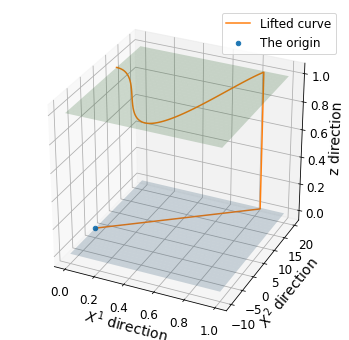

In [82]:
x,y,z=visibility_visualization2(x_path,y_path)
yy, xx = np.meshgrid(np.arange(31)-10,range(2))
zz = yy*0

yy1, xx1 = np.meshgrid(np.arange(31)-10,range(2))
zz1 = yy1*0+1

mpl.rcParams['legend.fontsize'] = 12

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, zz,alpha=0.2)
ax.plot(x, y, z, label='Lifted curve')
ax.scatter(0,0,0,label="The origin")
ax.plot_surface(xx1, yy1, zz1,alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()
ax.view_init(30, 360-65)

ax.set_xlabel('$X^1$ direction',fontsize=14)

ax.set_ylabel('$X^2$ direction',fontsize=14)
ax.set_zlabel('z direction',fontsize=14)
#ax.view_init(30, 360-45)
#ax.xticks(fontsize=12)
#ax.yticks(fontsize=12)
plt.show()

 #### This is called *T-Visibility transformation* 
 
 
The discrete ${\mathbf{T}}$-visibility transformation (TVT) would give
\begin{equation*}\label{eqn:dTVT}
\begin{bmatrix}
1 \\
2 
\end{bmatrix}, 
\begin{bmatrix}
 3\\
 4
\end{bmatrix} \stackrel{\mbox{TVT}}{\Longrightarrow}\begin{bmatrix}
 1\\
 2 \\
 1
\end{bmatrix},
\begin{bmatrix}
 3\\
 4 \\
 1
\end{bmatrix},
\begin{bmatrix}
 3\\
 4 \\
 0
\end{bmatrix},
\begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}.
\end{equation*}

In [85]:
def pen_on_pen_off(data, initial=True):

 

    """

 

    pen_on_pen_off function is the visibility transformation on discrete data

 
    Input:

 

    data: (n,d)-shape numpy format data,

           n: number of observations; d: dimension

 

    initial: True or False

             True: initial position is important

             False: tail position is important

 

    Output:

 

    

    pened_data: (n+2,d+1)-shape numpy format data

    

 

    """    

 

    pened_data=np.zeros((data.shape[0]+2,data.shape[1]+1))

    if initial:

 
        pened_data[2:,:-1]=data
        pened_data[1,:-1]=data[0,:]
        pened_data[2:,-1]=np.ones(data.shape[0])

    else:

        pened_data[:-2,:-1]=data
        pened_data[-2,:-1]=data[-1,:]
        pened_data[:-2,-1]=np.ones(data.shape[0])        

    return pened_data

In [93]:
test_data=np.array([[1,2],[3,4]])
print(test_data)

[[1 2]
 [3 4]]


In [96]:
test_data_ivt=pen_on_pen_off(test_data, initial=True)
print(test_data_ivt)

[[0. 0. 0.]
 [1. 2. 0.]
 [1. 2. 1.]
 [3. 4. 1.]]


In [99]:
print(iisignature.sig(test_data_ivt,2))

[3.  4.  1.  4.5 5.  1.  7.  8.  2.  2.  2.  0.5]


In [97]:
test_data_tvt=pen_on_pen_off(test_data, initial=False)
print(test_data_tvt)

[[1. 2. 1.]
 [3. 4. 1.]
 [3. 4. 0.]
 [0. 0. 0.]]


In [101]:
print(iisignature.sig(test_data_tvt,2))

[-1.  -2.  -1.   0.5  0.  -2.   2.   2.  -2.   3.   4.   0.5]
